## Q1. Implement Auto-Encoder for latent representation of MNIST dataset.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils import data
import torchvision.transforms as t
from torchvision.datasets import MNIST

In [2]:
EPOCHS = 20
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_TEST = 1000
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, 50),
            nn.Sigmoid(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [4]:
def train(model, train_loader, criterion, optimizer, device="cpu"):
    model.train()
    running_loss = 0.0
    for data, _ in train_loader:
        data = data.to(device)
        target = torch.empty_like(data).copy_(data)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss /= len(train_loader)
    return running_loss

def test(model, test_loader, criterion, device="cpu"):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            target = torch.empty_like(data).copy_(data)
            output = model(data)
            running_loss += criterion(output, target).item()
    running_loss /= len(test_loader)
    return running_loss

In [5]:
train_dataset = MNIST('data/', train=True, download=True, transform=t.ToTensor())
test_dataset = MNIST('data/', train=False, download=True, transform=t.ToTensor())

train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=True)

In [6]:
model = AutoEncoder().to(DEVICE)

print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=100, out_features=784, bias=True)
    (4): Sigmoid()
  )
)


In [7]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [8]:
for epoch in range(1, EPOCHS + 1):
    print(f"Epoch: {epoch}")

    print("\tTraining: ", end='')
    train_loss = train(model, train_loader, criterion, optimizer, DEVICE)
    print("Loss: {:.6}".format(train_loss))

    print("\tTesting: ", end='')
    test_loss = test(model, test_loader, criterion, DEVICE)
    print("Loss: {:.6}".format(test_loss))

    print()


Epoch: 1
	Training: Loss: 0.275081
	Testing: Loss: 0.241396

Epoch: 2
	Training: Loss: 0.230498
	Testing: Loss: 0.200173

Epoch: 3
	Training: Loss: 0.191819
	Testing: Loss: 0.170909

Epoch: 4
	Training: Loss: 0.17728
	Testing: Loss: 0.15945

Epoch: 5
	Training: Loss: 0.168909
	Testing: Loss: 0.149973

Epoch: 6
	Training: Loss: 0.162849
	Testing: Loss: 0.144057

Epoch: 7
	Training: Loss: 0.158819
	Testing: Loss: 0.139755

Epoch: 8
	Training: Loss: 0.155664
	Testing: Loss: 0.135875

Epoch: 9
	Training: Loss: 0.15324
	Testing: Loss: 0.132807

Epoch: 10
	Training: Loss: 0.151086
	Testing: Loss: 0.130347

Epoch: 11
	Training: Loss: 0.149367
	Testing: Loss: 0.128278

Epoch: 12
	Training: Loss: 0.147952
	Testing: Loss: 0.126568

Epoch: 13
	Training: Loss: 0.146897
	Testing: Loss: 0.125222

Epoch: 14
	Training: Loss: 0.145919
	Testing: Loss: 0.124196

Epoch: 15
	Training: Loss: 0.145211
	Testing: Loss: 0.122918

Epoch: 16
	Training: Loss: 0.144499
	Testing: Loss: 0.122378

Epoch: 17
	Training:

In [9]:
import matplotlib.pyplot as plt

In [10]:
NUM_COLUMNS = 5

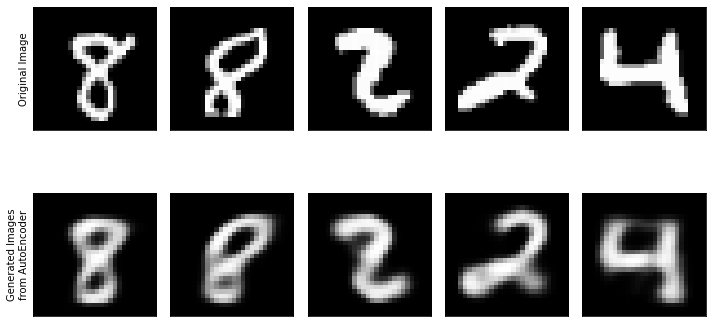

In [11]:
iterator = iter(test_loader)
data, _ = next(iterator)
out = model(data.to(DEVICE))

tensor2image = t.ToPILImage()

fig, axs = plt.subplots(2, NUM_COLUMNS, figsize=(10, 6))
axs[0, 0].set_ylabel('Original Image')
axs[1, 0].set_ylabel('Generated Images\nfrom AutoEncoder')
for i in range(NUM_COLUMNS):
    axs[0, i].imshow(tensor2image(data[i]), cmap = 'gray')
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])

    axs[1, i].imshow(tensor2image(out[i]), cmap='gray')
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])

plt.tight_layout()
plt.show()

## Q2. Implement VAE for synthesizing digits using MNIST training data.


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils import data
import torchvision.transforms as t
from torchvision.datasets import MNIST


In [13]:
EPOCHS = 20
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_TEST = 1000
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super(VariationalAutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, 50),
            nn.Sigmoid(),
        )

        self.mean = nn.Linear(50, 10, bias=True)
        self.std = nn.Linear(50, 10, bias=True)

        self.decoder = nn.Sequential(
            nn.BatchNorm1d(10),
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        enc = self.encoder(x)
        mean = self.mean(enc)
        std = self.std(enc)
        z = mean + std * torch.randn_like(std)
        dec = self.decoder(z)
        dec = dec.view(-1, 1, 28, 28)
        return mean, std, dec


In [15]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = f.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD


In [16]:
def train(model, train_loader, criterion, optimizer, device="cpu"):
    model.train()
    running_loss = 0.0
    for data, _ in train_loader:
        data = data.to(device)
        target = torch.empty_like(data).copy_(data)
        optimizer.zero_grad()
        mean, std, output = model(data)
        loss = criterion(target, output, mean, std)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss /= len(train_loader)
    return running_loss

def test(model, test_loader, criterion, device="cpu"):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            target = torch.empty_like(data).copy_(data)
            optimizer.zero_grad()
            mean, std, output = model(data)
            loss = criterion(target, output, mean, std)
            running_loss += loss.item()
    running_loss /= len(test_loader)
    return running_loss


In [17]:
train_dataset = MNIST('data/', train=True, download=True, transform=t.ToTensor())
test_dataset = MNIST('data/', train=False, download=True, transform=t.ToTensor())

train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=True)


In [18]:
model = VariationalAutoEncoder().to(DEVICE)

print(model)


VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): Sigmoid()
  )
  (mean): Linear(in_features=50, out_features=10, bias=True)
  (std): Linear(in_features=50, out_features=10, bias=True)
  (decoder): Sequential(
    (0): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=10, out_features=50, bias=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=100, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=100, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [19]:
criterion = loss_function
optimizer = optim.Adam(model.parameters(), lr=LR)

In [20]:
for epoch in range(1, EPOCHS + 1):
    print(f"Epoch: {epoch}")

    print("\tTraining: ", end='')
    train_loss = train(model, train_loader, criterion, optimizer, DEVICE)
    print("Loss: {:.6}".format(train_loss))

    print("\tTesting: ", end='')
    test_loss = test(model, test_loader, criterion, DEVICE)
    print("Loss: {:.6}".format(test_loss))

    print()

Epoch: 1
	Training: Loss: 24239.3
	Testing: Loss: 1.38226e+05

Epoch: 2
	Training: Loss: 17752.5
	Testing: Loss: 1.22227e+05

Epoch: 3
	Training: Loss: 16440.6
	Testing: Loss: 1.1377e+05

Epoch: 4
	Training: Loss: 15765.3
	Testing: Loss: 1.09222e+05

Epoch: 5
	Training: Loss: 15374.4
	Testing: Loss: 1.06596e+05

Epoch: 6
	Training: Loss: 15146.4
	Testing: Loss: 1.04153e+05

Epoch: 7
	Training: Loss: 14939.6
	Testing: Loss: 1.0237e+05

Epoch: 8
	Training: Loss: 14786.6
	Testing: Loss: 1.01128e+05

Epoch: 9
	Training: Loss: 14662.6
	Testing: Loss: 1.00192e+05

Epoch: 10
	Training: Loss: 14580.5
	Testing: Loss: 99576.8

Epoch: 11
	Training: Loss: 14515.1
	Testing: Loss: 99100.8

Epoch: 12
	Training: Loss: 14448.8
	Testing: Loss: 98657.1

Epoch: 13
	Training: Loss: 14393.8
	Testing: Loss: 98296.7

Epoch: 14
	Training: Loss: 14360.9
	Testing: Loss: 97830.6

Epoch: 15
	Training: Loss: 14317.5
	Testing: Loss: 97687.1

Epoch: 16
	Training: Loss: 14275.2
	Testing: Loss: 97328.2

Epoch: 17
	Trai

In [21]:
import matplotlib.pyplot as plt
NUM_COLUMNS = 5

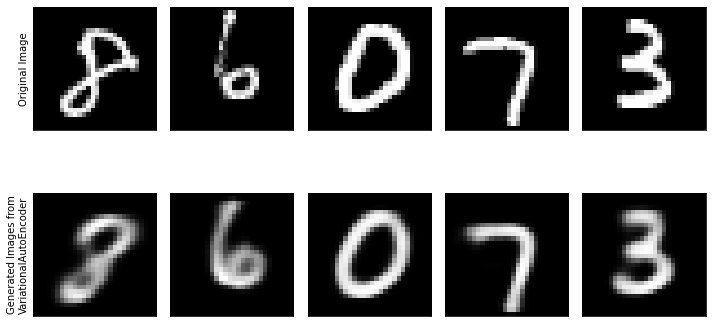

In [22]:
iterator = iter(test_loader)
data, _ = next(iterator)
mean, std, out = model(data.to(DEVICE))

tensor2image = t.ToPILImage()

fig, axs = plt.subplots(2, NUM_COLUMNS, figsize=(10, 6))
axs[0, 0].set_ylabel('Original Image')
axs[1, 0].set_ylabel('Generated Images from\nVariationalAutoEncoder')
for i in range(NUM_COLUMNS):
    axs[0, i].imshow(tensor2image(data[i]), cmap = 'gray')
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])

    axs[1, i].imshow(tensor2image(out[i]), cmap='gray')
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])

plt.tight_layout()
plt.show()


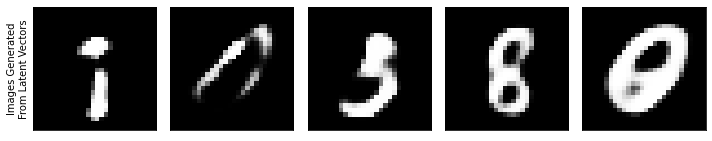

In [23]:
tensor2image = t.ToPILImage()

fig, axs = plt.subplots(1, NUM_COLUMNS, figsize=(10, 6))
axs[0].set_ylabel('Images Generated\nFrom Latent Vectors')
for i in range(NUM_COLUMNS):
    mean = torch.zeros((1, 10))
    var = torch.ones((1, 10))
    z_sample = mean + var * torch.randn_like(var)
    out = model.decoder(z_sample.to(DEVICE))
    out = out.view(-1, 28, 28)
    axs[i].imshow(tensor2image(out[0]), cmap = 'gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()
plt.show()
